<table>
<tr>
    <td width=10%><img src="./img/logo_lri.jpg"></td>
    <td width=30%><img src="./img/medi-chal_logo.png" height=15%></img></td>
</tr>

</table>

<br/><br/><div id="top"></div>

<center><a style="font-size: 40pt; font-weight: bold">
    Être ou ne pas être ?
</a></center>
<br/>
<center><a style="font-size: 22pt; font-weight: bold">
    Un problème de classification binaire sur des données médicales artificelles
<br/>

---

# Membres du groupe

**Minimum 2, Maximum 3**

<span style="color:red">
    Répondre ci-dessous
</span>

* Delplace, Alexis
* Ruiz Ocampo, Jacobo

# Présentation du challenge

## La question principale de ce challenge est : 

* Comment prédire la survie d'un patient compte tenu de son dossier médical ? 
    
* Plus précisément, vous devrez prédire la survie des patients pendant leur séjour à l'hôpital
 
Chaque jour, le personnel soignant collecte de nombreuses informations sur les patients en posant des questions et en utilisant des outils de mesure (stéthoscope, analyse de sang, capteurs, etc.). Ces données sont très utiles pour surveiller l'état de santé, diagnostiquer et choisir les traitements.

Elles peuvent également être utilisées pour l'analyse statistique prédictive.

## Données

L'ensemble de données contient des informations sur 80'000 patients, représentés par des variables (descripteurs) catégorielles, binaires et numériques. Ces variables sont, par exemple, l'âge, le sexe, l'origine ethnique, l'état matrimonial, ainsi que des données médicales telles que la tension artérielle ou le taux de glucose. Il y a un total de 342 variables.

La classe (étiquette ou label) à prédire est une variable binaire indiquant si le patient est décédé ou non pendant son séjour à l'hôpital. Heureusement, la plupart d'entre eux survivent :

![](img/tobe.png)

## Tâche

La tâche consiste à créer un modèle capable d'apprendre à partir des données et de faire des prédictions (apprentissage supervisé). Chaque instance (patient) possède une variable indiquant si elle·il est décédé·e ou non pendant son séjour à l'hôpital.

Références et crédit :

Isabelle Guyon, Kristin Bennett, Andrew Yale, Adrien Pavao, Thomas Gerspacher

## Instructions

Le but de ce TP est de travailler sur un challenge de prédiction de la mortalité.

Le lien vers le challenge :
https://competitions.codalab.org/competitions/30715

* **Étape 1 :** S'enregistrer sur https://competitions.codalab.org
* **Étape 2:** Téléchargez le jeu de données à partir de la [page](https://competitions.codalab.org/competitions/30715#participate-get_starting_kit) "Participate > Files > Public Data". Placez le dossier "public_data" dans le même dossier que celui contenant ce notebook.
* **Étape 3:** Parcourez ce notebook. Vous devrez lire, exécuter, **coder vos propres méthodes** et **répondre aux questions**. Utilisez la cellule ***code*** pour le codage et la cellule ***markdown*** pour répondre aux questions.

## Évaluation du projet

* **4 points** pour la partie compréhension et analyse exploratoire
    
* **4 points** pour un code propre et bien documenté

* **4 points** pour la qualité du modèle (sélection du modèle, sélection des hyperparamètres)

* **4 points** pour une bonne évaluation des performances du modèle

* **4 points** pour l'originalité et la complétude de la solution 

* **1 point bonus** pour l'équipe gagnante du challenge

### FAQ

* Soumettre uniquement le notebook sur eCampus

* La partie texte (explications, résultats, problèmes, sans le code) ne doit pas dépasser 3 pages A4 11pt (< 1500 mots)

# Challenge

Module particulier requis : `imblearn` (à installer avec `conda` ou `pip`)

* `conda install -c conda-forge imbalanced-learn`

* `pip install imbalanced-learn`

In [2]:
import time
from datetime import datetime
from pathlib import Path
from zipfile import ZipFile

import imblearn
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import (
    decomposition,
    discriminant_analysis,
    ensemble,
    linear_model,
    metrics,
    model_selection,
    naive_bayes,
    pipeline,
    preprocessing,
    svm,
)

In [3]:
%reload_ext autoreload
%autoreload 2

%config InlineBackend.figure_format="retina"  # For high DPI display

# Set precision for pd and np (np: suppress also sci notation)
np.set_printoptions(precision=3, suppress=True)
pd.options.display.float_format = "{:,.4g}".format

# TO DO : TABLE OF CONTENTS

## 1. Compréhension du problème

### Expliquez brièvement la tâche avec vos mots

<span style="color:red">
    Répondre ci-dessous
</span>

L'objectif du projet est d'utiliser des modèles d'apprentissage supervisé avec la library scikitlearn et des techniques de traitement de données pour classifier avec le plus d'accuracy possible si un patient est mort ou pas pendant son séjour à l'hopital. On va fit nos modeles avec un training dataset de 80000 patients déjà labeled et tune les
hyperparametres pour trouver le modèle le plus adapté puis l'utiliser pour predire les labels de données jamais vues auparavant.

### Pourquoi la métrique utilisée ici est la *balanced accuracy* plutôt que simplement l'*accuracy* ?

<span style="color:red">
    Répondre ci-dessous
</span>

Il faut comprendre que la distribution des patients entre les deux labels est très inégal, dans le training dataset environ 3% des patients meurt. Si on utilise la métrique accuracy il suffit de donner un modèle qui dit que le patient va pas mourir pour avoir 97% de accuracy ce qui n'est pas du tout un modèle prédictif correct (On peut pas prédire quel patients vont mourir). À cause de ce probleme, on utilise balanced accuracy qui tient en compte de la distribution inégal parmis les deux classes. 

## 2. Chargement les données

In [4]:
DATA = Path("public_data")

DROP_VARS = ["ADMITTIME", "DISCHTIME", "SUBJECT_ID", "HADM_ID"]

In [5]:
features = pd.read_csv(
    DATA / "mimic_synthetic_feat.name", header=None
).values.flatten()

labels = pd.read_csv(
    DATA / "mimic_synthetic_label.name", header=None
).values.flatten()

x_df = pd.read_csv(
    DATA / "mimic_synthetic_train.data",
    header=None,
    names=features,
    sep=" ",
)

# Remove time related data that are not needed
x_df.drop(columns=DROP_VARS, inplace=True)

ys = pd.Series(
    pd.read_csv(
        DATA / "mimic_synthetic_train.solution",
        header=None,
        names=labels,
        sep=" ",
    ).values.flatten()
)

In [6]:
x_df.head(3)

,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
0,Private,ENGL,CATHOLIC,DIVORCED,WHITE,F,21,57.21,108.7,70.84,...,0,0,0,0,0,0,0,0,0,0
1,Private,ENGL,UNOBTAINABLE,SINGLE,WHITE,M,39,79.33,121.1,96.92,...,0,0,0,0,0,0,0,0,0,1
2,Medicaid,SPAN,CATHOLIC,WIDOWED,OTHER,M,40,118.2,175.2,140.9,...,0,0,0,0,0,0,0,0,0,0


C'est **l'ensemble d'entrainement**. Cela signifie que vous avez accès aux étiquettes et que vous pouvez l'utiliser comme vous le souhaitez pour préparer votre modèle.

Plus tard, vous ferez en sorte que votre modèle tire des prédictions de **l'ensemble de test** afin de les télécharger sur Codalab et d'obtenir un score sur des données non-vues.

In [7]:
# Load testing set
x_test_df = pd.read_csv(
    DATA / "mimic_synthetic_test.data",
    header=None,
    names=features,
    sep=" ",
)

# Remove time related data that are not needed
x_test_df.drop(columns=DROP_VARS, inplace=True)

## 3. Analyse exploratoire

####  Types des variables  <a id='types'></a>

In [8]:
types = pd.read_csv(DATA / "mimic_synthetic_feat.type", header=None).set_index(
    features
)[0]

types.value_counts()

Numerical      226
Binary         107
Categorical      8
Name: 0, dtype: int64

#### Labels distribution

In [9]:
ys.describe()

count     8e+04
mean    0.03496
std      0.1837
min           0
25%           0
50%           0
75%           0
max           1
dtype: float64

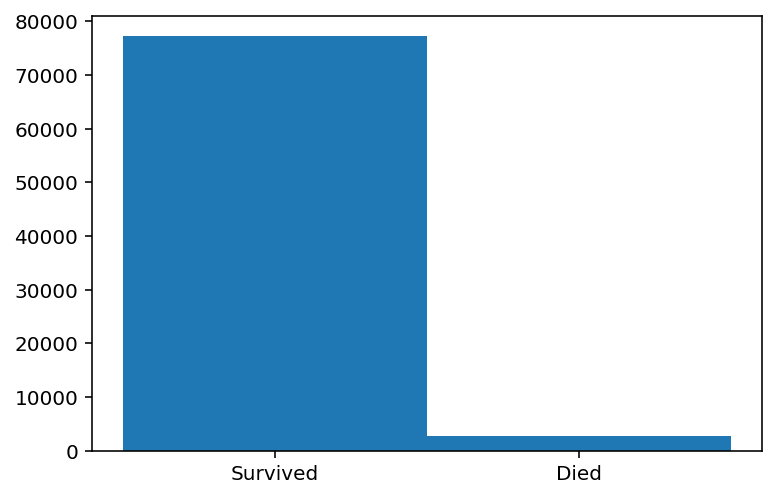

In [10]:
ys.hist(bins=2, grid=False, align="left")
plt.xticks([0, 0.5], ["Survived", "Died"])
# plt.savefig("img/tobe.png", dpi=300)
plt.show()

### Code : Produire les graphiques suivants

* Diagrammes à barres de certaines variables catégorielles (par exemple "LANGUAGE", "MARITAL_STATUS")

* Montrez la corrélation entre certaines variables et la variable cible y

* Un autre graphique ou toute analyse exploratoire à laquelle vous pouvez penser

### Step 1 : Datatypes / Null values

In [11]:
# Features datatype
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(x_df.dtypes.value_counts())

int64      279
float64     51
object       7
dtype: int64


On remarque ici que certaines features sont de type "object", il va donc falloir les traiter lors du prepocessing afin de pouvoir les utiliser dans nos models.

Les features de type "object" représente en règle général les variables catégorielles. Or, on remarque ici, que l'on a que 7 features de type "object", alors que d'après [types](#types), il y a dans le dataset, 8 features catégorielle. On  va donc regarder ça de plus près.

In [12]:
# Categorical features from the types file
print("types from \"mimic_synthetic_feat.type\" file :")
for feature, _type in types.pipe(lambda x: x[x == "Categorical"]).items():
    print(feature)

# Features that have an object type
print("\n", "types from dataset.dtypes() method :")
for feature, _type in x_df.dtypes.pipe(lambda x: x[x == "object"]).items():
    print(feature)

types from "mimic_synthetic_feat.type" file :
ADMITTIME
DISCHTIME
INSURANCE
LANGUAGE
RELIGION
MARITAL_STATUS
ETHNICITY
ICU

 types from dataset.dtypes() method :
INSURANCE
LANGUAGE
RELIGION
MARITAL_STATUS
ETHNICITY
GENDER
ICU


On peut voir que dans dataset.dtypes() on a plus "ADMITTIME" et "DISCHTIME" car on les drop plus haut dans le notebook. On ne retrouve pas "GENDER" en tant que variable catégorielle dans le fichier des type car on considère que l'on est soit un homme soit une femme. C'est un peut pertubant puisque la variable "GENDER" est de type object et prends commme valeur "F" ou "M" (0 ou 1 aurait été plus logique au vu du "Binary").  
Mais au final, il n'y a donc pas de problèmes concernant les types du dataset.

In [13]:
print(types.loc["GENDER"])

Binary


In [14]:
# Number of features that have NaN values
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(x_df.isnull().any().value_counts())


False    331
True       6
dtype: int64


On remarque ici que certaines features ont des valeurs null pour certain labels, il va donc falloir ici aussi s'en occuper lors du preprocessing. Pour se rendre compte du nombre de null values dans notre dataset, on va afficher le nombre de valeur nulles pour chaque features.

In [15]:
# Features that have NaN values (with a their NaN values counter)
for feature, counter in x_df.isnull().sum().items():
    if counter > 0:
        print(feature, ":", counter)

LANGUAGE : 1
MARITAL_STATUS : 1
ICU : 2
ECodes:Adverseeffectsofmedicalcare : 6
Otnutritdx : 2
Othnervdx : 1


On s'aperçoit que l'on a que très peut de valeurs null. Il est utile préférable de supprimer la feature du dataset si on a trop de valeurs null (ex : 70%) pour celle ci.  
Ici ça n'est pas le cas, ce qui est une bonne nouvelle pour la suite.

### Step 2 : Visualization

Exemple founis

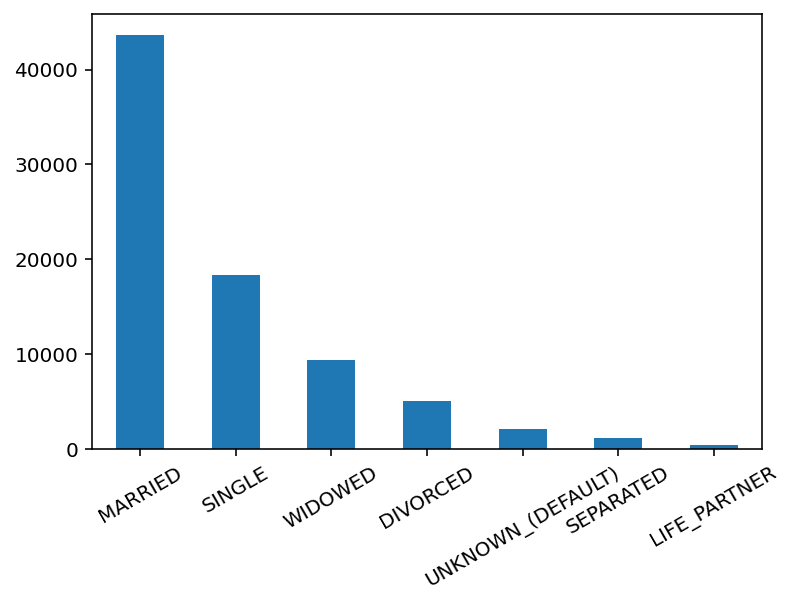

In [16]:
x_marital_cnts = x_df["MARITAL_STATUS"].value_counts()
x_marital_cnts.plot.bar(rot=30)
plt.show()

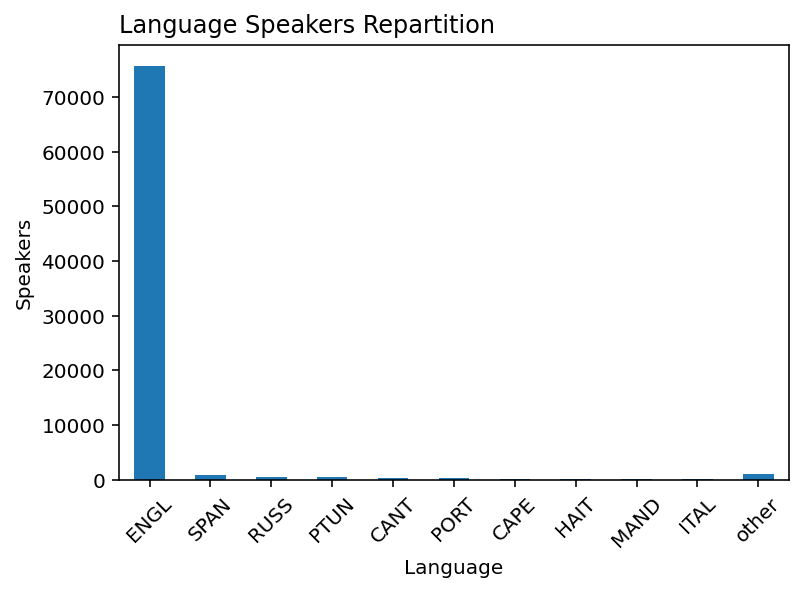

In [17]:
counts = x_df.LANGUAGE.value_counts()
threshold = 100

# Get all language with more than 100 speakers
mask = counts > threshold

# Get number of speakers than dont speak a language with more than 100 speakers
tail_counts = counts.loc[~mask].sum()

# Add the most spoken languages (>100 speakers)
language = counts.loc[mask]

# Regroup all speakers who dont speak a language with more than 100 speakers in the "other" category
language['other'] = tail_counts

# Plot
language.plot(kind='bar')
plt.xticks(rotation=45)
plt.title("Language Speakers Repartition", loc='left')
plt.xlabel("Language")
plt.ylabel("Speakers")
plt.show()

#### Correlations

In [18]:
# Copy dataset
dataset_df = x_df.copy()

# Add target to dataset
dataset_df['DIED'] = ys

# Get correlation matrix
corr = dataset_df.corr()

# Get correlation between all variables and y ('DIED')
# and drop 'DIED' x varible
corr_DIED = corr.DIED.drop('DIED')

<AxesSubplot:>

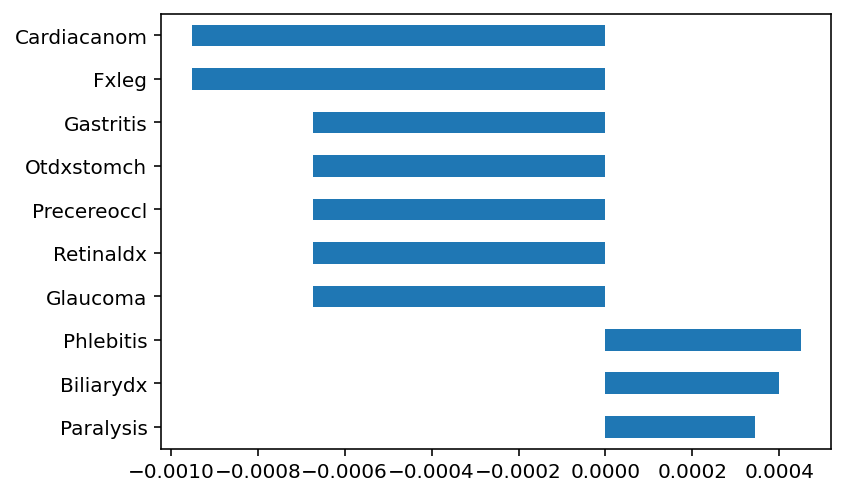

In [19]:
# Re order variables by correlation coefficient absolute value
most_correlated = corr_DIED.reindex(corr_DIED.abs().sort_values().index)

# Plot top 10 variables (ordered)
most_correlated.head(10).plot(kind='barh')

Hint:

* Utilisez un graphique avec des barres horizontales `barh` (pour visualiser les valeurs positives et négatives)

<span style="color:red">
    Utiliser des cellules markdown pour ajouter des commentaires
</span>

#### Autres graphiques

In [20]:
# TODO: Add graph

<span style="color:red">
    Utiliser des cellules markdown pour ajouter des commentaires
</span>

## 4. Preprocessing

### Code : Traitement du problème des valeurs manquantes (ou non-définies, NAN)

La solution la plus simple est d'éliminer l'ensemble des colonnes où il y a des données manquantes, mais on perd de l'information. 

Notez qu'il faut supprimer l'union des colonnes en question pour l'ensemble d'entrainement et de test, afin de garder des dimensions cohérentes.

In [21]:
print(x_df.shape, x_test_df.shape)

(79999, 337) (20001, 337)


In [22]:
x_nans = x_df.isna().sum()
x_miss = x_nans[x_nans > 0]
x_miss

LANGUAGE                              1
MARITAL_STATUS                        1
ICU                                   2
ECodes:Adverseeffectsofmedicalcare    6
Otnutritdx                            2
Othnervdx                             1
dtype: int64

In [23]:
x_test_nans = x_test_df.isna().sum()
x_test_miss = x_test_nans[x_test_nans > 0]
x_test_miss

LANGUAGE                              2
ECodes:Adverseeffectsofmedicalcare    3
dtype: int64

### Traitements des NaN

In [24]:
# Provided method
def drop_columns(train, test, display=False):
    """
     Returns train and test dataset without columns containing NaN values
     
     Parameters:
         train (dataframe)
         test (dataframe)
    """
    
    # Get columns with NaN values
    na_cols = set(train.columns[train.isna().any()]) | set(test.columns[test.isna().any()])
    if display:
        print("Removed columns :", na_cols)
    
    # Retrun datasets without them
    return (train.drop(columns=na_cols), test.drop(columns=na_cols))

Proposez d'autre(s) stratégie(s) pour traiter le problème des NAN.

In [25]:
def drop_rows(train, test):
    """
     Returns train and test dataset without rows containing NaN values
     
     Parameters:
         train (dataframe):
         test (dataframe):
    """
    
    return x_df.dropna(), x_test_df.dropna()    

In [26]:
def fill_prev (train, test):
    """
    Filling the cell containing NaN values with previous entry
    """
    
    na_cols = set(train.columns[train.isna().any()])
    for col in na_cols:
        train[col] = train[col].fillna(method='ffill').fillna(method='bfill')
    na_cols =  set(test.columns[test.isna().any()])
    for col in na_cols:
        test[col] = test[col].fillna(method='ffill').fillna(method='bfill')
    return train, test

In [27]:
def fill_median (train, test):
    """
    Filling the cell containing NaN values with column's median
    """
    
    na_cols = set(train.columns[train.isna().any()])
    for col in na_cols:
        median = train[col].median()
        train[col].fillna(median, inplace=True)
        
    na_cols =  set(test.columns[test.isna().any()])
    for col in na_cols:
        median = test[col].median()
        test[col].fillna(median, inplace=True)
    return train, test

### Evaluation des méthodes traitants les NaN

In [28]:
def nan_values_method_evaluation(method):
    """
    Evaluates and display metrics about method 
    
    Parameters:
         method (function): method dealing with NaN values
    """
    
    train, test = method(x_df, x_test_df)
    
    print("Train Dataset :")
    print("\t", "Default shape :", x_df.shape)
    print("\t", "Processed shape :", train.shape)
    print("\t", "NaN values :", train.isna().any().any())
    
    print("Test Dataset :")
    print("\t", "Default shape :", x_test_df.shape)
    print("\t", "Processed shape :", test.shape)
    print("\t", "NaN values :", test.isna().any().any())

In [29]:
methods = [drop_columns, drop_rows, fill_prev, fill_median]

for method in methods:
    print("Method :", method.__name__)
    nan_values_method_evaluation(method)
    print("\n")

Method : drop_columns
Train Dataset :
	 Default shape : (79999, 337)
	 Processed shape : (79999, 331)
	 NaN values : False
Test Dataset :
	 Default shape : (20001, 337)
	 Processed shape : (20001, 331)
	 NaN values : False


Method : drop_rows
Train Dataset :
	 Default shape : (79999, 337)
	 Processed shape : (79986, 337)
	 NaN values : False
Test Dataset :
	 Default shape : (20001, 337)
	 Processed shape : (19996, 337)
	 NaN values : False


Method : fill_prev
Train Dataset :
	 Default shape : (79999, 337)
	 Processed shape : (79999, 337)
	 NaN values : False
Test Dataset :
	 Default shape : (20001, 337)
	 Processed shape : (20001, 337)
	 NaN values : False


Method : fill_median
Train Dataset :
	 Default shape : (79999, 337)
	 Processed shape : (79999, 337)
	 NaN values : False
Test Dataset :
	 Default shape : (20001, 337)
	 Processed shape : (20001, 337)
	 NaN values : False




In [30]:
x_df, x_test_df = fill_median(x_df, x_test_df)

### Domain Expertise

Simplifier les données pour notamment regrouper les catégories rares.

In [31]:
def merge_rare_categories(dfs, col, keeps=None, keep_n=5):
    if keeps is None:
        keeps = x_df[col].value_counts()[:keep_n].index
        print(keeps)

    for df in dfs:
        df.loc[~df[col].isin(keeps), col] = "OTHER"

In [32]:
merge_rare_categories([x_df, x_test_df], col="RELIGION", keep_n=5)
print(x_test_df["RELIGION"].value_counts())

Index(['CATHOLIC', 'NOT_SPECIFIED', 'UNOBTAINABLE', 'PROTESTANT_QUAKER',
       'JEWISH'],
      dtype='object')
CATHOLIC             7517
NOT_SPECIFIED        3764
OTHER                2449
UNOBTAINABLE         2208
PROTESTANT_QUAKER    2208
JEWISH               1855
Name: RELIGION, dtype: int64


#### Code : Effectuez des regrouppements de catégories rares pour d'autres variables si vous le jugez nécessaire

Analyse de toutes les features ayant pour object pour type

In [33]:
# Get Index of features name that have an "object" datatype
char_cols = x_df.dtypes.pipe(lambda x: x[x == "object"]).index

for feature in char_cols.values:
    
    # Number of possible values for feature
    number_of_possible_values = len(x_test_df[feature].value_counts().keys())
    
    # If the number of possible values is greater than 5, then display all possible values for this feature
    if number_of_possible_values > 5:
        print("Feature", feature)
        with pd.option_context('display.max_rows', None, 'display.max_columns', None):
            display(x_test_df[feature].value_counts())
        print("\n")

Feature LANGUAGE


ENGL    18883
SPAN      258
RUSS      151
PTUN      147
CANT       77
PORT       69
CAPE       43
HAIT       41
MAND       26
ITAL       23
VIET       21
*CRE       18
HIND       14
ARAB       14
GREE       13
POLI       11
AMER       11
PERS       10
ALBA        8
*ARM        8
BENG        7
KORE        7
ETHI        7
**SH        7
CAMB        7
THAI        6
JAPA        6
TURK        5
*DEA        5
*AMH        5
LAOT        4
*ROM        4
*_FU        4
FREN        4
*CHI        4
*CDI        4
SOMA        4
*_BE        4
*NEP        4
*BUL        3
*GUJ        3
URDU        3
*URD        3
*DUT        3
*LEB        3
*CAN        3
*BOS        3
*FUL        3
*YID        2
*YOR        2
*BEN        2
*FAR        2
*SPA        2
*IBO        2
**TO        2
*KHM        2
*TEL        2
*PHI        2
*TOI        2
*LIT        2
*ARA        1
*RUS        1
*BUR        1
*TAM        1
SERB        1
*HUN        1
Name: LANGUAGE, dtype: int64



Feature RELIGION


CATHOLIC             7517
NOT_SPECIFIED        3764
OTHER                2449
UNOBTAINABLE         2208
PROTESTANT_QUAKER    2208
JEWISH               1855
Name: RELIGION, dtype: int64



Feature MARITAL_STATUS


MARRIED              10856
SINGLE                4635
WIDOWED               2400
DIVORCED              1217
UNKNOWN_(DEFAULT)      497
SEPARATED              301
LIFE_PARTNER            95
Name: MARITAL_STATUS, dtype: int64



Feature ETHNICITY


WHITE                                         14930
UNKNOWN/NOT_SPECIFIED                          1088
BLACK/AFRICAN_AMERICAN                          930
OTHER                                           406
UNABLE_TO_OBTAIN                                380
HISPANIC_OR_LATINO                              377
ASIAN                                           354
PATIENT_DECLINED_TO_ANSWER                      264
ASIAN_-_CHINESE                                 144
BLACK/CAPE_VERDEAN                              112
HISPANIC/LATINO_-_PUERTO_RICAN                  111
WHITE_-_RUSSIAN                                  99
WHITE_-_OTHER_EUROPEAN                           70
HISPANIC/LATINO_-_DOMINICAN                      68
BLACK/HAITIAN                                    60
MULTI_RACE_ETHNICITY                             60
ASIAN_-_VIETNAMESE                               56
ASIAN_-_ASIAN_INDIAN                             51
WHITE_-_BRAZILIAN                                46
BLACK/AFRICA

In [34]:
# Display metrices about english speakers
print("Total speakers :", sum(x_test_df["LANGUAGE"].value_counts()))
print("English speakers :", x_test_df["LANGUAGE"].value_counts().values[0])
print("Non english speakers :", sum(x_test_df["LANGUAGE"].value_counts().values[1:-1]))
print("English speakers percentage :", x_test_df["LANGUAGE"].value_counts().values[0] / sum(x_test_df["LANGUAGE"].value_counts()) * 100)

Total speakers : 20001
English speakers : 18883
Non english speakers : 1117
English speakers percentage : 94.4102794860257


Au vu du pourcentage élevé d'anglophones, il n'est pas idiots de réduire le champs des possibles de notre feature "LANGUAGE" à 2 options, anglpphone ou non anglophone.

In [35]:
merge_rare_categories([x_df, x_test_df], col="LANGUAGE", keep_n=2)
print(x_test_df["LANGUAGE"].value_counts())

Index(['ENGL', 'SPAN'], dtype='object')
ENGL     18883
OTHER      860
SPAN       258
Name: LANGUAGE, dtype: int64


In [36]:
# TODO : ETHNICITY, maybe idk.

### Transformation des données catégorielles en nombres entiers en utilisant deux type d'encodage

Les variables catégorielles sont présentées sous forme de chaines de caractères. La plupart des modèles ne pourront pas les prendre en entrée.

Deux des méthodes les plus simples sont `LabelEncoder` de Scikit-Learn et `factorize` de pandas. Elles consistent simplement à remplacer chaque nouvelle catégorie rencontrée par un entier, en commençant par 0. Ce n'est cependant peut-être pas la méthode la plus efficace, car elle présuppose une proximité entre la catégories de valeurs proches.

In [37]:
def label_encode(df, other_df, only_binary=False):

    char_cols = df.dtypes.pipe(lambda x: x[x == "object"]).index
    # print(char_cols)

    for col in char_cols:
        n_categories = len(x_df[col].unique())

        if not only_binary or n_categories == 2:
            codes, uniques = pd.factorize(df[col])
            df[col] = codes

            # Create conversion dic to convert values of test set as well
            cat2code = {k: v for v, k in enumerate(uniques)}
            other_df[col] = other_df[col].map(cat2code)

In [38]:
x_df.head(3)

,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
0,Private,ENGL,CATHOLIC,DIVORCED,WHITE,F,21,57.21,108.7,70.84,...,0,0,0,0,0,0,0,0,0,0
1,Private,ENGL,UNOBTAINABLE,SINGLE,WHITE,M,39,79.33,121.1,96.92,...,0,0,0,0,0,0,0,0,0,1
2,Medicaid,SPAN,CATHOLIC,WIDOWED,OTHER,M,40,118.2,175.2,140.9,...,0,0,0,0,0,0,0,0,0,0


In [39]:
print(x_df.shape, ys.shape)

(79999, 337) (79999,)


In [40]:
x_fact_df = x_df.copy()
x_test_fact_df = x_test_df.copy()

label_encode(x_fact_df, x_test_fact_df)

In [41]:
x_fact_df.head(3)

,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
0,0,0,0,0,0,0,21,57.21,108.7,70.84,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,1,0,1,39,79.33,121.1,96.92,...,0,0,0,0,0,0,0,0,0,1
2,1,1,0,2,1,1,40,118.2,175.2,140.9,...,0,0,0,0,0,0,0,0,0,0


In [42]:
x_test_fact_df.head(3)

,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
0,3,0,5,3,0,0,18,72.64,112.7,96.46,...,0,0,0,0,0,0,0,0,0,0
1,2,0,2,1,4,0,56,66.61,106.8,83.85,...,0,0,0,0,0,0,0,0,1,0
2,1,0,0,1,0,1,32,69.72,102.7,87.26,...,0,0,0,0,0,0,0,0,0,0


### Encodage 1-Hot

Un autre type d'encodage est souvent plus efficace, il a notamment l'avantage de ne pas ordonner les classes d'une manière particulière (pas forcément en adéquation avec la proximité de ces classes entre elles).

Une méthode de pandas permet de le réaliser en 1 ligne de code.

In [43]:
codes, uniques = pd.factorize(x_df["RELIGION"])
cat2code = {k: v for v, k in enumerate(uniques)}
cat2code

{'CATHOLIC': 0,
 'UNOBTAINABLE': 1,
 'NOT_SPECIFIED': 2,
 'JEWISH': 3,
 'PROTESTANT_QUAKER': 4,
 'OTHER': 5}

Exemple d'encodage 1-hot avec la fonction `get_dummies` de pandas (pour MARITAL_STATUS) :

|    |   DIVORCED |   LIFE_PARTNER |   MARRIED |   SEPARATED |   SINGLE |   UNKNOWN_(DEFAULT) |   WIDOWED |
|---:|-----------:|---------------:|----------:|------------:|---------:|--------------------:|----------:|
|  0 |          1 |              0 |         0 |           0 |        0 |                   0 |         0 |
|  1 |          0 |              0 |         0 |           0 |        1 |                   0 |         0 |
|  2 |          0 |              0 |         0 |           0 |        0 |                   0 |         1 |
|  3 |          0 |              0 |         1 |           0 |        0 |                   0 |         0 |
|  4 |          0 |              0 |         1 |           0 |        0 |                   0 |         0 |

In [44]:
# 1-Hot enconding
x_all_1hot_df = pd.get_dummies(pd.concat([x_df, x_test_df]))

x_1hot_df = x_all_1hot_df[: len(x_df)]
x_test_1hot_df = x_all_1hot_df[len(x_df) :]

print(x_df.shape, x_test_df.shape)
print(x_1hot_df.shape, x_test_1hot_df.shape)

(79999, 337) (20001, 337)
(79999, 399) (20001, 399)


On a donc 99-37=62 nouvelles features après l'encodage 1-hot. On va vérifier que c'est bien cohérent.

In [45]:
dummies_counter = 0
# Get all categorical variables (object types)
object_cols = x_df.dtypes.pipe(lambda x: x[x == "object"]).index

# For each categorical variables, display the number of new variables created by the 1-Hot encoding
for col in object_cols:
    dummies = pd.get_dummies(x_df[col])
    new_columns = len(dummies.columns)
    dummies_counter += new_columns
    print(col, new_columns)

print("TOTAL", dummies_counter)

INSURANCE 5
LANGUAGE 3
RELIGION 6
MARITAL_STATUS 7
ETHNICITY 41
GENDER 2
ICU 5
TOTAL 69


On a donc un total de 69 features qui sont générées via l'encodage 1-Hot. On doit donc avoir :
* +337 features orginales 
* +69 features générées via l'encodage 1-hot
* -7 features encodé via 1-hot (à savoir nos features de type object : "INSURANCE ", "LANGUAGE", ...)
* =399

Le compte est bon.

### Création de l'ensemble de validation

In [46]:
x_train, x_valid, y_train, y_valid = model_selection.train_test_split(
    x_1hot_df, ys, test_size=0.3
)
# VARS: x_df, x_fact_df, x_1hot_df

#### PCA

Testez la PCA pour réduire le nombre de dimensions et voir si cela améliore le résultat.

Avant d'appliquer la PCA, il est conseillé de centrer-réduire les données (e.g., via `preprocessing.StandardScaler()`).

<span style="color:red">
    Répondre ci-dessous
</span>

In [83]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def standardize(x_train, x_valid):
    
    scaler = preprocessing.StandardScaler()
    x_train = scaler.fit_transform(x_train)
    
    scaler = preprocessing.StandardScaler()
    x_valid = scaler.fit_transform(x_valid)
    
    return x_train, x_valid


def normalize(x_train, x_valid):
    
    scaler = preprocessing.MinMaxScaler()
    x_train = scaler.fit_transform(x_train)
    
    scaler = preprocessing.MinMaxScaler()
    x_valid = scaler.fit_transform(x_valid)
    
    return x_train, x_valid   
    
    
def pca(n_components, x_train, x_valid):
        
    pca = decomposition.PCA(n_components=n_components)
    x_train = pca.fit_transform(x_train)
    x_valid = pca.fit_transform(x_valid)
    
    return x_train, x_valid

In [48]:
X_train, X_valid = normalize(x_train, x_valid)
X_train, X_valid = pca(100, X_train, X_valid)

Proposez un graphique qui représente les 2 premières dimensions de la PCA et commentez succinctement.

<span style="color:red">
    Répondre ci-dessous
</span>

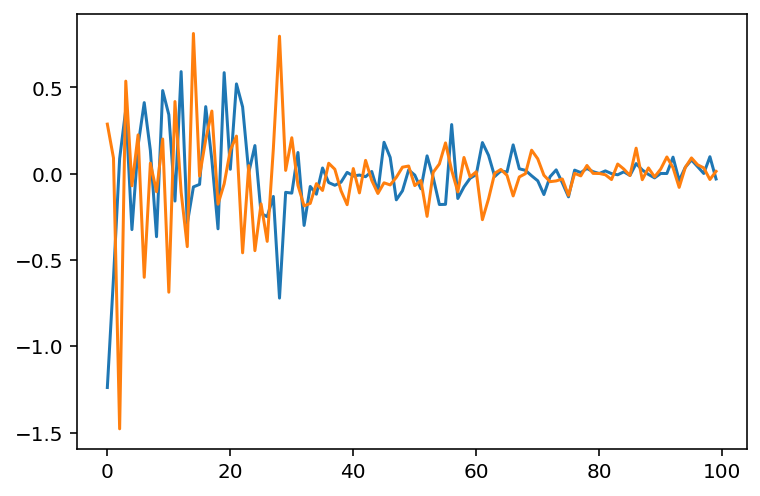

In [49]:
plt.plot(X_train[0])
plt.plot(X_train[1])
plt.show()

<span style="color:red">
    Utiliser des cellules markdown pour ajouter des commentaires
</span>

## 5. Modèles de classification

Entrainez le modèle

### Baseline

`LogisticRegression` or `RandomForestClassifier`

In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

models = {LogisticRegression(random_state=0, max_iter=10000) : "Logistic Regression", 
          DecisionTreeClassifier(random_state=0) : "Decision Tree",
          RandomForestClassifier(random_state=0, n_estimators=10) : "Random Forest",
          KNeighborsClassifier() : "KNeighbors", 
          SVC(max_iter=1000) : "SVC"
         }

# training
for model in models:
    model = model.fit(X_train, y_train)

C:\Users\Alexis\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


## 6. Évaluations

In [52]:
from sklearn.metrics import accuracy_score

print("Balanced accuracy score:")
for model in models:
    
    y_pred = model.predict(X_valid)  # predictions
    balanced_accuracy_score = metrics.balanced_accuracy_score(y_valid, y_pred)  # scoring
    
    print(model, " : ", balanced_accuracy_score)
    y_valid.value_counts()

Balanced accuracy score:
LogisticRegression(max_iter=10000, random_state=0)  :  0.5020638519567405
DecisionTreeClassifier(random_state=0)  :  0.5027713187000805
RandomForestClassifier(n_estimators=10, random_state=0)  :  0.5001973471858413
KNeighborsClassifier()  :  0.5008915190141848
SVC(max_iter=1000)  :  0.5148110671025508


### Code : Validation croisée

Le code ci-dessus utilise une méthode simple (*hold out*) pour mesurer le score de validation. Utilisez la validation croisée (pour obtenir une estimation plus fiable) combinée à l'exploration des hyperparamètres (pour améliorer les résultats).

Vous pouvez changer la valeur du nombre de validation croisée (CV) selon la valeur de l'erreur et le temps d'entrainement des modèles (compromis).

In [53]:
CV = 10
SCORINGS = "balanced_accuracy"

In [54]:
from sklearn.model_selection import cross_val_score

model = LogisticRegression(random_state=0, max_iter=100)
CV_accuracy = cross_val_score(model, X_train, y_train, scoring=SCORINGS, cv=CV)  # scoring


print("Cross-Validation balanced accuracy :")
print("Logistic Regression :", CV_accuracy)

Cross-Validation balanced accuracy :
Logistic Regression : [0.513 0.508 0.502 0.505 0.51  0.505 0.502 0.502 0.505 0.505]


In [84]:
# Generates X_train X_valid for all algorithms with different pca n_component value

n_components = [10, 50, 100, 150, 170]

models = {LogisticRegression(random_state=0, max_iter=10000) : "Logistic Regression", 
          DecisionTreeClassifier(random_state=0) : "Decision Tree",
          RandomForestClassifier(random_state=0, n_estimators=10) : "Random Forest",
          KNeighborsClassifier() : "KNeighbors", 
          SVC(max_iter=1000) : "SVC"
         }

x_train_scaled, x_valid_scaled = standardize(x_train, x_valid)


print("Process PCA :")

pca_results = []
for model in models:
    
    model_name = models.get(model)
    t0 = time.perf_counter()
    
    pca_model = []
    for n_component in n_components:
        
        X_train, X_valid = pca(n_component, x_train_scaled, x_valid_scaled)
        pca_model.append((n_component, (X_train, X_valid)))
        
    pca_results.append((model, pca_model))
    
    t1 = time.perf_counter()
    print(f"{model_name} : {t1 - t0:0.4f} seconds")

Process PCA :
Logistic Regression : 21.0510 seconds
Decision Tree : 24.2656 seconds
Random Forest : 22.7024 seconds
KNeighbors : 23.8558 seconds
SVC : 21.6438 seconds


* **Pour 2 des modèles** (au moins 1 autre que les 2 proposés en baselines) :

    * Pour différentes valeurs d'un des hyperparamètres, donnez les `balanced_accuracy` moyennes de la validation croisée sous forme de Boxplots (ou de diagramme à bâtons avec une barre d'erreur) : voir l'exemple présenté dans le graphique ci-dessous. 
    
    * Explicitez succinctement quelles observations en tirer concernant la stabilité des prédictions.

![](img/boxplot-cv.png)

<span style="color:red">
    Répondre ci-dessous
</span>

In [ ]:
# Compute Cross-Validation

n_components = [10, 50, 100, 150, 170]

models = {LogisticRegression(random_state=0, max_iter=10000) : "Logistic Regression", 
          DecisionTreeClassifier(random_state=0) : "Decision Tree",
          RandomForestClassifier(random_state=0, n_estimators=10) : "Random Forest",
          KNeighborsClassifier() : "KNeighbors", 
          SVC(max_iter=1000) : "SVC"
         }




x_train_scaled, x_valid_scaled = standardize(x_train, x_valid)


print("Process Cross-Validation :")

cv_scores = []
for model in models:
    
    model_name = models.get(model)
    cv_score_model = []
    
    t0 = time.perf_counter()
    for n_component in n_components:

        X_train, X_valid = pca(n_component, x_train_scaled, x_valid_scaled)
        cv_score_model.append(cross_val_score(model, X_train, y_train, scoring=SCORINGS, cv=2))
    
    cv_scores.append( (model_name, cv_score_model) )
    
    t1 = time.perf_counter()
    print(f"{model_name} : {t1 - t0:0.4f} seconds")

In [86]:
print("Process Cross-Validation :")

cv_scores = []
for model, sets in pca_results:
    
    model_name = models.get(model)
    t0 = time.perf_counter()
    
    cv_score_model = []
    for set in sets:
        
        n_components = set[0]
        X_train = set[1][0]
        X_valid = set[1][1]
        
        cv_score_model.append(cross_val_score(model, X_train, y_train, scoring=SCORINGS, cv=2))
    
    cv_scores.append((model_name, cv_score_model))
    
    t1 = time.perf_counter()
    print(f"{model_name} : {t1 - t0:0.4f} seconds")
        

Process Cross-Validation :
Logistic Regression : 10.7650 seconds
Decision Tree : 89.6267 seconds
Random Forest : 39.4543 seconds
KNeighbors : 215.2229 seconds


C:\Users\Alexis\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Alexis\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Alexis\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Alexis\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

SVC : 173.0045 seconds


In [ ]:
for model, cv_score in cv_scores:
    
    f, ax = plt.subplots()
    plt.title(model)
    plt.xlabel('param_pca_n_components')
    plt.ylabel('balanced_accuracy')
    plt.boxplot(cv_score)
    ax.set_xticklabels(["10", "50", "100", "150", "170"])
plt.show

<span style="color:red">
    Utiliser des cellules markdown pour ajouter des commentaires
</span>

* **Pour le modèle et sa combinaison d'hyperparamètres offrant le meilleur résultat** :

    * Réalisez la matrice de confusion et décrivez-la succinctement.

<span style="color:red">
    Utiliser des cellules markdown pour ajouter des commentaires
</span>

* **Pour chacun de ces 2 modèles, à partir des données de validation créées précédemment** (`x_valid`, `y_valid`) :

    * Mesurez l'aire sous la courbe ROC (AUC) à l'aide de la fonction de Scikit-Learn (`roc_auc_score`) et comparez les modèles avec leur combinaison respective d'hyperparamètres offrant le meilleur résultat.

In [1]:

n_components = [10]

models = {LogisticRegression(random_state=0, max_iter=10000) : "Logistic Regression", 
          DecisionTreeClassifier(random_state=0) : "Decision Tree",
          RandomForestClassifier(random_state=0, n_estimators=10) : "Random Forest",
          KNeighborsClassifier() : "KNeighbors", 
          SVC(max_iter=1000) : "SVC"
         }

for model in models:
    
    ROC=[]
    
    for n_component in n_components:

        X_train, X_valid = standardize_and_pca(n_component, x_train, x_valid)

        clf = model
        clf.fit(X_train, y_train)  # training

        y_pred = clf.predict(X_valid)  # predictions
        
        roc = roc_auc_score(y_valid, clf.predict(X_valid))
        print(roc)
        ROC.append(roc)
    
    plt.title("ROC")
    plt.bar(n_components, ROC, bottom=0.45)
    plt.show()

NameError: name 'LogisticRegression' is not defined

<span style="color:red">
    Utiliser des cellules markdown pour ajouter des commentaires
</span>

### Code : Essayez d'améliorer votre score

* Data augmentation (optionnel)

Vu le déséquilibre entre les classes à prédire (survive, died), on peut espérer améliorer le score en les rééquilibrant. Une approche typique est la génération de données (voir slides du cours 6). Une des méthodes de génération est implémentée dans le module `imblearn`.

`imblearn` a été développé pour s'interfacer facilement avec `sklearn`.
Il propose notamment une version du `pipeline` qui permet l'intégration avec `sklearn`.

Ci-dessous voici un exemple de `pipe` intégrant `imblearn` et `sklearn`.

<span style="color:red">
    Répondre ci-dessous
</span>

In [ ]:
# TODO: Data augmentation

pipe = imblearn.pipeline.Pipeline(
    [
        ("scale", preprocessing.StandardScaler()),
        ("pca", decomposition.PCA()),
        ("resample", imblearn.over_sampling.SMOTE()),
        ("model", model),
    ]
)

In [ ]:
#SMOTE
Xb=pd.DataFrame(x_train)
Yb=pd.DataFrame(y_train)

from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=2)
x_train, y_train = sm.fit_resample(Xb, np.ravel(Yb))

### Explication de ce que vous avez réalisé, conclusion et perspectives

* Commencez par donner votre meilleur résultat obtenu lors de vos soumissions

* Expliquez le chemin qui vous y a conduit

    * Ce que vous avez essayé :

        * Ce qui a fonctionné

        * Ce qui n'a pas fonctionné et comment vous l'avez solutionné

    * Quelle méthode avez-vous utilisée pour choisir les hyperparamètres ?

    * Comparer la durée d'entrainement des principaux modèles utilisés ?

* Qu'auriez-vous fait si vous aviez eu plus de temps ?

<span style="color:red">
    Répondre ci-dessous
</span>

TODO: Le meilleur resultat obtenu est 0.76 obtenu apres minmaxscalar suivi d'un SMOTE

### Question (optionnelle)

* Qu'est-ce que le suréchantillonnage ? 

* En quoi pourrait-il être utile dans ce problème ?

<span style="color:red">
    Répondre ci-dessous
</span>

* Le suréchantillonnage est une technique utilisé pour ajuster la distribution des données entre les classes en augmentant les données de la classe minoritaire sous representée à fin d'arriver a un ratio classe minoritaire/classe majoritaire convenable pour l'apprentisage.

* Dans ce problème la classe minoritaire sous représentée est la classe des patients qui meurent, si on augmente les échantillons de patients qui meurent on peut fit notre modèle avec un dataset équilibrée sur lequel les algorithmes d'apprentissage sont plus effectifs.

## 7. Enregistrer les prédictions

* Utilisez le code suivant pour faire des prédictions et pour les enregistrer sous forme de fichier ZIP
* Soumettez ce fichier ZIP sur [le site du challenge](https://competitions.codalab.org/competitions/30715#participate-submit_results)
("Participate > Submit/View Results > Submit")
* Faites de votre mieux pour être le ***premier sur le leaderboard !***

<span style="color:red">
    !! Ne pas oublier de modifier la commande de la prédiction selon les données et modèles choisis !!
</span>

* Données : `x_test_fact_df`, `x_test_1hot_df`

* Modèles : `model`, `search` (e.g., pour le `GridSearchCV`)

In [ ]:
predictions = model.predict(x_test_1hot_df)  # compute predictions
# VARS: x_test_df, x_test_fact_df, x_test_1hot_df, x_test_1hot_pcs
# Models: model, search


predictions_file = "mimic_synthetic_test.csv"

pd.Series(predictions).to_csv(predictions_file, index=False, header=False)

print("Predictions saved.")

t_stamp = time.asctime().replace(" ", "_").replace(":", "-")

output_file = f"submission_{t_stamp}.zip"

!zip test_submission.zip mimic_synthetic_test.csv  # create a ZIP

with ZipFile(output_file, "w") as z:
    z.write(predictions_file)

print(f"The submission is ready: {output_file}")

---

# Remarque sur le jeu de données

Le jeu de données ne contient pas de données médicales réelles. Nous ne sommes pas autorisés à partager ces **données confidentielles** provenant de patients en soins intensifs. Pour éviter ce problème, les données ont été remplacées par des **données artificielles**.

Afin d'avoir des données crédibles, elles ont été générées à l'aide d'un **Wasserstein GAN**.

Pour plus d'informations, voici une référence : <br />
[Privacy Preserving Synthetic Health Data](https://hal.inria.fr/hal-02160496/document) <br />
Andrew Yale, Saloni Dash, Ritik Dutta, Isabelle Guyon, Adrien Pavao, Kristin Bennett <br />

---